# Quickstart: Use Cases and Examples with *Open Bandit Pipeline*
---
This notebook shows an example of conducting an offline evaluation of the performance of Bernoulli Thompson Sampling (BernoulliTS) as a counterfactual policy using OPE estimators and logged bandit feedback generated by the Random policy (behavior policy).

Our example with Open Bandit Dataset (OBD) contains the follwoing three major steps:
- (1) Data loading and preprocessing
- (2) Offline Bandit Simulation
- (3) Off-Policy Evaluation

In [1]:
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier as RandomForest
# import open bandit pipeline (obp)
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.simulator import run_bandit_simulation
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    ReplayMethod,
    DirectMethod,
    DoublyRobust
)

## (1) Data loading and preprocessing

We prepare easy-to-use data loader for Open Bandit Dataset, **OpenBanditDataset** class in dataset module. <br>
It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [2]:
# (1) Data loading and preprocessing
# specify path of dataset
data_path = Path('.').resolve().parents[1] / 'obd'
# load and preprocess raw data in "Women" campaign collected by the Random policy (behavior policy here)
dataset = OpenBanditDataset(behavior_policy='random', campaign='women', data_path=data_path)
# obtain logged bandit feedback generated by behavior polciy
bandit_feedback = dataset.obtain_batch_bandit_feedback()

# `bandit_feedback` is a dictionary storing logged bandit feedback
bandit_feedback.keys()

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

### let's see some properties of the dataset class

In [3]:
# name of the dataset is 'obd' (open bandit dataset)
dataset.dataset_name

'obd'

In [4]:
# number of actions of the "Women's" campaign is 46
dataset.n_actions

46

In [5]:
# small sample example data has 10,000 rounds
dataset.n_rounds

10000

In [6]:
# default context (feature) engineering creates context vector with 19 dimensions
dataset.dim_context

19

In [7]:
# ZOZOTOWN recommendation iterface has three positios
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3

## (2) Offline Bandit Simulation

After preparing the data, we now run **offline bandit simulation**. <br>
We use **Bernoulli TS** impelemted in policy module as a counterfacutal policy. <br>
`run_bandit_simulation` in simulation module takes a counterfactual policy and a training dataset as inputs and run the policy on the dataset.

In [8]:
# (2) Offline Bandit Simulation
# define counterfacutal policy, which is the Bernoulli TS policy here
counterfactual_policy = BernoulliTS(n_actions=dataset.n_actions, len_list=dataset.len_list, random_state=1)
# run Bernoulli Thompson Sampling on the bandit feedback
action_dist = run_bandit_simulation(bandit_feedback=bandit_feedback, policy=counterfactual_policy)

# action_dist is an array of shape (n_rounds, n_actions, len_list) 
# representing the distribution over actions by the counterfactual policy
action_dist

100%|██████████| 10000/10000 [00:00<00:00, 34943.39it/s]


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

## (3) Off-Policy Evaluation (OPE)

Our final step is **off-policy evaluation**, which attempts to estimate the performance of bandit algorithms using log data generated by offline bandit simulation. We use the *ReplayMethod*, *DirectMethod*, and *Doubly Robust* estimators as OPE estimators and estiamte the performance of Bernoulli TS using the simulation log data. Finally, we summarize and visualize the results of OPE.

In [9]:
# estimate the policy value of BernoulliTS based on its distribution over actions
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,  
    regression_model=RegressionModel(
        n_actions=dataset.n_actions,
        len_list=dataset.len_list,
        base_model=RandomForest(n_estimators=100, random_state=12345)
    ),
    action_context=dataset.action_context,
    ope_estimators=[ReplayMethod(), DirectMethod(), DoublyRobust()]
)

# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(action_dist=action_dist)

In [10]:
# ground-truth policy value of the random policy
# , which is the empirical mean of the factual (observed) rewards (on-policy estimation)
ground_truth = bandit_feedback['reward'].mean()

# add estimated policy value relative to the ground-truth policy value of 
# the behavior policy (the Random policy here)
estimated_policy_value['relative_estimated_policy_value'] =\
        estimated_policy_value.estimated_policy_value / ground_truth

In [11]:
# estimated policy value of BernoulliTS by OPE estimators 
estimated_policy_value

,estimated_policy_value,relative_estimated_policy_value
rm,0.005155,1.120574
dm,0.001497,0.325328
dr,0.005936,1.290328


In [12]:
# estimated confidence intervals of policy value of BernoulliTS by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure 
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval

,mean,95.0% CI (lower),95.0% CI (upper)
rm,0.005206,0.000000,0.020619
dm,0.001517,0.001338,0.001700
dr,0.006536,0.001086,0.017608


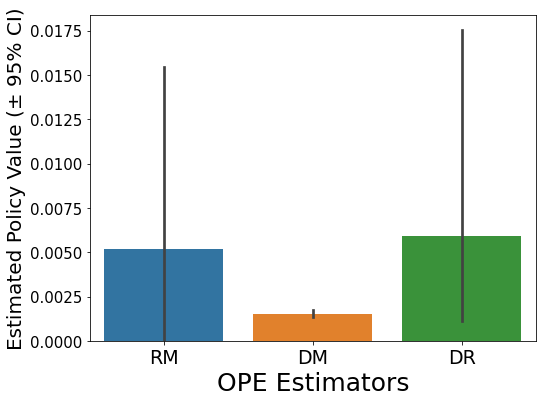

In [13]:
# visualize the estimated policy values of BernoulliTS by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(action_dist=action_dist)

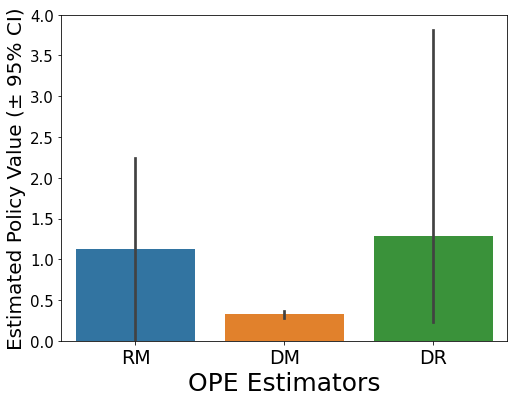

In [14]:
# by activating the `relative` option
# we can visualize the estimated policy value of counterfactual policy
# relative to the ground-truth policy value of behavior policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    relative=True
)

Note that the example of OPE here is with the small size example version of our OBD, and please use the full size version to produce more reasonable results